# Table of Contents
* [Dependency](#de)
* [Setting models / onnx files](#se)
* [Summary & speed graph](#su)

Speed Comparison Results
1. [Pytorch](#rcpu)
2. [ONNX Runtime](#onnx)
    * [static onnx](#onnxs)
    * [dynamic onnx](#onnxd)
    * [static onnx pycpp](#pycpp)
    * [static onnx cpp api](#cpp)
3. [tvm](#tvm)
    * [untuned tvm](#utvmr)
    * [tuned tvm](#tvmr)
4. [openvino](#vino)
5. [outputs comparison](#out)




# <a name="su">Summary</a>
* Outputs from different frameworks are mostly the same. (mse=e-10)
* OpenVINO is 1.7x ~ 2.2x faster than Pyotrch. It's the best approach so far.
* ONNX Runtime is approximately 1.3x ~ 2x faster than Pytorch.

* Untuned TVM is slower than Pytorch, but the potential of Tuned TVM is big. (taking much time too)
* ONNX Runtime C++ API is not only slower than python API but also Pytorch, probably not the best implementation or too much overhead.
* ONNX Runtime using ctypes to call c++ implemented function is much more slower, probably due to too much calling overhead.

* If time budget is less, use OpenVINO or ONNX Runtime. If having a lot of time, use tvm auto scheduling to tune.
* Easy to use: ONNX Runtime > OpenVINO >>> TVM

/home/luhsuanwen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


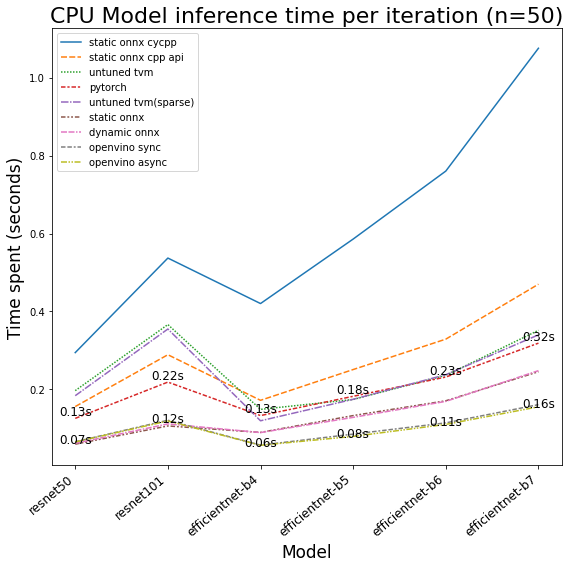

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

speed = {}
for k, v in sorted(time_spent.items(), key=lambda x:x[1][2], reverse=True):
   speed[k]=v 
speed["name"] = model_name_list
df = pd.DataFrame(speed)


plt.figure(figsize=(8, 8))
ax = sns.lineplot(data=df)
ax.set_xticklabels([0]+df["name"].to_list(), rotation=40, ha="right", fontsize=12)
ax.set_title("CPU Model inference time per iteration (n=50)", fontsize=22)
ax.set_xlabel("Model", fontsize=17)
ax.set_ylabel("Time spent (seconds)", fontsize=17)
plt.tight_layout()
for i in df.index:
    raw_value = df.loc[i, "pytorch"]
    vino_value = df.loc[i, "openvino async"]
    plt.annotate(f"{raw_value:.2f}s", (i, raw_value), ha="center", va="bottom", fontsize=12)
    plt.annotate(f"{vino_value:.2f}s", (i, vino_value-0.01), ha="center", va="bottom", fontsize=12)

# <a name="de">Dependency

In [1]:
# install onnx / onnxruntim / efficientnet first
import onnx
import onnxruntime
import torch
import torch.nn as nn
from torchvision import models
import os
import numpy as np
import cv2
import time
from efficientnet_pytorch import EfficientNet

In [2]:
def pytorch_to_onnx(model, model_path, input_shape=(1, 3, 224, 224), opset_version=11):        
    input_data = torch.randn(input_shape)
    torch.onnx.export(model.eval(), input_data, model_path, opset_version=opset_version)
    print('Export Finished, now Checking ONNX Model')    
    get_and_check_onnx_model(model_path)

def pytorch_to_onnx_dynamic(
        model, 
        model_path, 
        input_shape=(1, 3, 224, 224),
        input_name="input.1",
        output_name="output",
        dynamic_axes={"input.1": {2:'width', 3:'height'}, "output": {1:'classes'}}, 
        opset_version=11
    ):        
    input_data = torch.randn(input_shape)            
    torch.onnx.export(model.eval(), input_data, model_path, input_names=[input_name], output_names=[output_name], dynamic_axes=dynamic_axes, opset_version=opset_version)
    print('Export Finished, now Checking ONNX Model')    
    get_and_check_onnx_model(model_path)

def time_calculator(func):
    def wrap(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        end = time.time()
        time_spend = end - start
        print('time_spend: ', time_spend)
        return time_spend
    return wrap
    
def get_and_check_onnx_model(model_path):
    import onnx
    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)
    print('if nothing showed, then the model is fine.')
    return onnx_model

def set_efficient_model_ready(model):
    model.set_swish(memory_efficient=False)
    return model


def _calculate_dhdw_half(h, w):
    """Calculate difference of h or w in order to get a square """
    if h > w:
        dh_half = int(0.1*h/2)
        dw_half = int((h+2*dh_half-w)/2)
    else:
        dw_half = int(0.1*w/2)
        dh_half = int((w+2*dw_half-h)/2)
    return dh_half, dw_half
    
def preprocess_onnx(image):
    # 加邊框
    h, w, c = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dh_half, dw_half = _calculate_dhdw_half(h, w)
    image = cv2.copyMakeBorder(image, dh_half, dh_half, dw_half, dw_half, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (248, 248))[12:236, 12:236]/255.0
    image = image.transpose(2, 0, 1).astype(np.float32)[np.newaxis,:]
    return image

def preprocess_pt(image):
    # 加邊框
    h, w, c = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dh_half, dw_half = _calculate_dhdw_half(h, w)
    image = cv2.copyMakeBorder(image, dh_half, dh_half, dw_half, dw_half, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (248, 248))[12:236, 12:236]
    tensor = torch.tensor(image, dtype=torch.float)    
    return tensor.permute(2, 0, 1).div(255.0).unsqueeze(0)

def show_onnx_session_io_name(session):
    session.get_modelmeta()
    first_input_name = session.get_inputs()[0].name
    first_output_name = session.get_outputs()[0].name
    print(first_input_name, first_output_name)
    
def onnxruntime_inference(ort_session, image):
    image = preprocess_onnx(image)
    ort_inputs = {ort_session.get_inputs()[0].name: image}
    ort_outs = ort_session.run(None, ort_inputs)
    return ort_outs


# <a name="se">Setting models / onnx files

In [3]:
time_spent = {}
ROOT = "/home/luhsuanwen/project/"
model_name_list = ["resnet50", "resnet101", "efficientnet-b4", "efficientnet-b5", "efficientnet-b6", "efficientnet-b7"]
model_path_list = []
dynamic_model_path_list = []
model_list = []
class_num = 801
n = 50
for name in model_name_list:
    if name.startswith("res"):
        model = getattr(models, name)(pretrained=True)
        num_input_fts = model.fc.in_features
        model.fc = nn.Linear(num_input_fts, class_num)
        torch.manual_seed(0)
        w = torch.randn(class_num, num_input_fts)
        b = torch.randn(class_num)
        model.fc.bias.data = b
        model.fc.weight.data = w
    else:
        model = EfficientNet.from_pretrained(name)
        model = set_efficient_model_ready(model)
        num_input_fts = model._fc.in_features
        model._fc = nn.Linear(num_input_fts, class_num)
        torch.manual_seed(0)        
        w = torch.randn(class_num, num_input_fts)
        b = torch.randn(class_num)
        model._fc.bias.data = b
        model._fc.weight.data = w
    print(name, ": partial weights: \n  ", w[0][:5], "\n")
    model_path = ROOT + "ONNX_MODELS/" + name + ".onnx"
    dynamic_model_path = ROOT + "ONNX_MODELS/" + name + "_dynamic.onnx"
    model_path_list.append(model_path)
    dynamic_model_path_list.append(dynamic_model_path)
    model_list.append(model)
    if not os.path.exists(model_path):
        pytorch_to_onnx(model.eval(), model_path, opset_version=10)
    if not os.path.exists(dynamic_model_path):
        pytorch_to_onnx_dynamic(model.eval(), dynamic_model_path, opset_version=10)

resnet50 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 

resnet101 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 

Loaded pretrained weights for efficientnet-b4
efficientnet-b4 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 

Loaded pretrained weights for efficientnet-b5
efficientnet-b5 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 

Loaded pretrained weights for efficientnet-b6
efficientnet-b6 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 

Loaded pretrained weights for efficientnet-b7
efficientnet-b7 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 



# <a name="rcpu">Pytorch Speed


In [5]:
time_spent["pytorch"] = []
raw_output_list = []
for name, model in zip(model_name_list, model_list):
    model.cpu()
    model.eval() 
    test_image = cv2.imread(ROOT + "sample.jpg")
    tensor = preprocess_pt(test_image)
    output = model(tensor.cpu())        
    start = time.time()
    for _ in range(n):
        test_image = cv2.imread(ROOT + "sample.jpg")
        tensor = preprocess_pt(test_image)
        output = model(tensor.cpu())        
        score, pred = torch.max(output, dim=1)
    end = time.time()
    raw_output_list.append(output)
    time_cost = (end-start)/n
    print(name, time_cost)
    time_spent["pytorch"].append(time_cost)

resnet50 0.1256297779083252
resnet101 0.21878520488739014
efficientnet-b4 0.13286421298980713
efficientnet-b5 0.1822823715209961
efficientnet-b6 0.2317064571380615
efficientnet-b7 0.31871959686279294


# <a name="onnx">ONNX Runtime

## <a name="onnxs">Static ONNX Speed

In [98]:
onnx_output_list = []
time_spent["static_onnx"] = []
for name, model_path in zip(model_name_list, model_path_list):
    
    session = onnxruntime.InferenceSession(model_path)
#     show_onnx_session_io_name(session)
    test_image = cv2.imread(ROOT + "sample.jpg")
    outputs = onnxruntime_inference(session, test_image)
    
    start = time.time()
    for _ in range(n):
        test_image = cv2.imread(ROOT + "sample.jpg")
        outputs = onnxruntime_inference(session, test_image)
    end = time.time()
    onnx_output_list.append(outputs)
    time_cost = (end-start)/n
    print(name, os.path.basename(model_path), time_cost)
    time_spent["static_onnx"].append(time_cost)

resnet50 resnet50.onnx 0.05939744472503662
resnet101 resnet101.onnx 0.10621201992034912
efficientnet-b4 efficientnet-b4.onnx 0.08963496685028076
efficientnet-b5 efficientnet-b5.onnx 0.13283960342407228
efficientnet-b6 efficientnet-b6.onnx 0.17082993030548096
efficientnet-b7 efficientnet-b7.onnx 0.24540993213653564


## <a name="onnxd">Dynamic ONNX Speed

In [99]:
time_spent["dynamic_onnx"] = []

onnx_dynamic_output_list = []
for name, model_path in zip(model_name_list, dynamic_model_path_list):    
    session = onnxruntime.InferenceSession(model_path)
#     show_onnx_session_io_name(session)
    test_image = cv2.imread(ROOT + "sample.jpg")
    outputs = onnxruntime_inference(session, test_image)
    
    start = time.time()
    for _ in range(n):
        test_image = cv2.imread(ROOT + "sample.jpg")
        outputs = onnxruntime_inference(session, test_image)
    end = time.time()
    onnx_dynamic_output_list.append(outputs)
    time_cost = (end-start)/n
    print(name, os.path.basename(model_path), time_cost)
    time_spent["dynamic_onnx"].append(time_cost)

resnet50 resnet50_dynamic.onnx 0.06164608478546143
resnet101 resnet101_dynamic.onnx 0.11144033908843994
efficientnet-b4 efficientnet-b4_dynamic.onnx 0.08921420574188232
efficientnet-b5 efficientnet-b5_dynamic.onnx 0.12822016716003418
efficientnet-b6 efficientnet-b6_dynamic.onnx 0.16922220706939697
efficientnet-b7 efficientnet-b7_dynamic.onnx 0.2481519412994385


## <a name="pycpp">Static ONNX PyCpp Speed

In [103]:
import ctypes
from numpy.ctypeslib import ndpointer
so_path = "/home/luhsuanwen/project/DeepLearningDeployment/onnxruntime/python_cpp_extension/libonnxpy.so"
onnx_cpp_output_list = []
time_spent["onnx_pycpp"] = []
for name in model_name_list:    
    model_path = ROOT + "ONNX_MODELS/" + name + ".onnx"
    image_path = ROOT + "sample.jpg"
    modelPath = model_path.encode(encoding="utf-8")
    imagePath = image_path.encode(encoding="utf-8")    

    dll = ctypes.cdll.LoadLibrary(so_path)
    dll.onnx_inference.restype = ctypes.POINTER(ctypes.c_float)
    dll.onnx_inference.restype = ndpointer(dtype=ctypes.c_float, shape=(801,))
    dll.onnx_inference.argtypes = [ctypes.c_char_p, ctypes.c_char_p]
    outputs_np = dll.onnx_inference(modelPath, imagePath)
    
    start = time.time()
    for _ in range(n):
        outputs_np = dll.onnx_inference(modelPath, imagePath)
    end = time.time()
    onnx_cpp_output_list.append(outputs_np)
    time_cost = (end-start)/n
    print(name, os.path.basename(model_path), time_cost)
    time_spent["onnx_pycpp"].append(time_cost)

resnet50 resnet50.onnx 0.2944345569610596
resnet101 resnet101.onnx 0.5370899295806885
efficientnet-b4 efficientnet-b4.onnx 0.42034742355346677
efficientnet-b5 efficientnet-b5.onnx 0.5858522129058837
efficientnet-b6 efficientnet-b6.onnx 0.7603125143051147
efficientnet-b7 efficientnet-b7.onnx 1.075557703971863


## <a name="cpp">Static ONNX Cpp Api Speed

In [60]:
time_spent["onnx cpp api"] = [0.156, 0.289, 0.172, 0.251, 0.329, 0.47]

# <a name="tvm">TVM

In [5]:
import tvm
from tvm import relay, auto_scheduler
from tvm.relay import data_dep_optimization as ddo
import tvm.relay.testing
from tvm.contrib import graph_executor

# Define the neural network and compilation target.
# If the target machine supports avx512 instructions, replace the
# "llvm -mcpu=core-avx2" with "llvm -mcpu=skylake-avx512"
class cfg:
    input_name = "input.1"
    batch_size = 1
    input_shape = (3, 224, 224)
    output_shape = (batch_size, 801)
    dtype = "float32"
    layout = "NCHW"    
    opset_version = 10
    target = "llvm"
    dev = tvm.device(str(target), 0)

def preprocess_tvm(image):
    # 加邊框
    h, w, c = image.shape
    np_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dh_half, dw_half = _calculate_dhdw_half(h, w)
    np_img = cv2.copyMakeBorder(np_img, dh_half, dh_half, dw_half, dw_half, cv2.BORDER_REPLICATE)
    np_img = cv2.resize(np_img, (248, 248))[12:236, 12:236]/255.0
    return np_img.transpose(2, 0, 1)[np.newaxis, :]

def tvm_inference(module, img):
    module.set_input(cfg.input_name, tvm.nd.array(img.astype(cfg.dtype)))
    module.run()
    tvm_output = module.get_output(0)
    return tvm_output

def get_network_from_onnx(
    model_path, 
    input_name="input.1", 
    input_shape=(1, 3, 224, 224), 
    dtype="float32"
):
    onnx_model = onnx.load(model_path)
    shape_dict = {input_name: input_shape}
    mod, params = relay.frontend.from_onnx(onnx_model, shape=shape_dict, dtype=dtype)
    return mod, params
    
def convert_layout(mod):
    desired_layouts = {'nn.conv2d': ['NHWC', 'default']}
    seq = tvm.transform.Sequential([relay.transform.RemoveUnusedFunctions(),
                                    relay.transform.ConvertLayout(desired_layouts)])
    with tvm.transform.PassContext(opt_level=3):
        mod = seq(mod)
    return mod

def get_tvm_module_N_params(
    model_path, 
    input_name="input.1",
    batch_size=1,
    input_shape=(3, 224, 224),
    layout="NHWC", 
    dtype="float32", 
    use_sparse=False
):
    """Get the symbol definition and random weight of a network"""

    data_shape = (batch_size,) + input_shape
    # auto-scheduler prefers NHWC layout
    mod, params = get_network_from_onnx(model_path, input_name, data_shape, dtype)
    if layout == "NHWC":
        mod = convert_layout(mod)
    # net = mod["main"]
#     net = relay.Function(net.params, relay.nn.softmax(net.body), None, net.type_params, net.attrs)
#     mod = tvm.IRModule.from_expr(net)

    if use_sparse:
        from tvm.topi.sparse.utils import convert_model_dense_to_sparse
        mod, params = convert_model_dense_to_sparse(mod, params, bs_r=4, random_params=True)
    return mod, params


## <a name="utvmr">Untuned TVM Results

In [35]:
untuned_tvm_output_list = []
key1 = "untuned tvm"
key2 = "untuned tvm(sparse)"
time_spent[key1] = []
time_spent[key2] = []

for use_sparse, key, in [[False, key1], [True, key2]]:
    for model_name, model_path in zip(model_name_list, model_path_list):
        layout = "NCHW"
        json_file = "TVM_FILES/%s-%s-B%d-%s-sparse%d.json" % (model_name, layout, cfg.batch_size, cfg.target.kind.name, use_sparse)
        
        mod, params = get_tvm_module_N_params(
            model_path, 
            use_sparse=use_sparse,
            layout = layout
        )

        with tvm.transform.PassContext(opt_level=3):
            lib = relay.build(mod, target=cfg.target, params=params)

        # # Create graph executor
        module = graph_executor.GraphModule(lib["default"](cfg.dev))

        test_image = cv2.imread(ROOT + "sample.jpg")
        test_image = preprocess_tvm(test_image)
        tvm_inference(module, test_image)

        start = time.time()
        for i in range(n):
            test_image = cv2.imread(ROOT + "sample.jpg")
            test_image = preprocess_tvm(test_image)
            outputs = tvm_inference(module, test_image)
        end = time.time()
        untuned_tvm_output_list.append(outputs)
        time_cost = (end-start)/n
        print(model_name, ",use sparse:", use_sparse, layout, time_cost)
        time_spent[key].append(time_cost)

resnet50 ,use sparse: False NCHW 0.19686517238616943
resnet101 ,use sparse: False NCHW 0.3663997793197632
efficientnet-b4 ,use sparse: False NCHW 0.1487484121322632
efficientnet-b5 ,use sparse: False NCHW 0.17417756080627442
efficientnet-b6 ,use sparse: False NCHW 0.23612546443939209
efficientnet-b7 ,use sparse: False NCHW 0.351676778793335
resnet50 ,use sparse: True NCHW 0.18388869285583495
resnet101 ,use sparse: True NCHW 0.3550059938430786
efficientnet-b4 ,use sparse: True NCHW 0.11945239067077637
efficientnet-b5 ,use sparse: True NCHW 0.17457947731018067
efficientnet-b6 ,use sparse: True NCHW 0.2377849578857422
efficientnet-b7 ,use sparse: True NCHW 0.3399813461303711


## <a name="tvmr">Tuned TVM Result

In [6]:
tuned_tvm_output_list = []
key1 = "tuned(2k) tvm(nhwc)"
key2 = "tuned(2k) tvm(nhwc, sparse)"
key3 = "tuned(2k) tvm(nchw)"
time_spent[key1] = []
time_spent[key2] = []
time_spent[key3] = []

for key, use_sparse, layout in [[key1, False, "NHWC"], [key2, True, "NHWC"], [key3, False, "NCHW"]]:
    for model_name, model_path in zip(model_name_list, model_path_list):
        json_file = "/home/luhsuanwen/project/TVM_FILES/%s-%s-B%d-%s-sparse%d.json" % (model_name, layout, cfg.batch_size, cfg.target, use_sparse)
        print(key, use_sparse, layout, model_name, json_file)
        mod, params = get_tvm_module_N_params(
            model_path, 
            layout=layout,
            use_sparse=use_sparse,
        )

        with auto_scheduler.ApplyHistoryBest(json_file):
            with tvm.transform.PassContext(opt_level=3, config={"relay.backend.use_auto_scheduler": True}):
                lib = relay.build(mod, target=cfg.target, params=params)

        # Create graph executor
        module = graph_executor.GraphModule(lib["default"](cfg.dev))

        test_image = cv2.imread(ROOT + "sample.jpg")
        test_image = preprocess_tvm(test_image)
        tvm_inference(module, test_image)

        start = time.time()
        for i in range(n):
            test_image = cv2.imread(ROOT + "sample.jpg")
            test_image = preprocess_tvm(test_image)
            outputs = tvm_inference(module, test_image)
        end = time.time()
        tuned_tvm_output_list.append(outputs)
        time_cost = (end-start)/n
        print(model_name, use_sparse, time_cost)
        time_spent[key].append(time_cost)

tuned(2k) tvm(NHWC) False NHWC resnet50 /home/luhsuanwen/project/TVM_FILES/resnet50-NHWC-B1-llvm-sparse0.json
resnet50 False 0.21792710781097413
tuned(2k) tvm(NHWC) False NHWC resnet101 /home/luhsuanwen/project/TVM_FILES/resnet101-NHWC-B1-llvm-sparse0.json
resnet101 False 0.36384995937347414
tuned(2k) tvm(NHWC) False NHWC efficientnet-b4 /home/luhsuanwen/project/TVM_FILES/efficientnet-b4-NHWC-B1-llvm-sparse0.json
efficientnet-b4 False 0.1598656177520752
tuned(2k) tvm(NHWC) False NHWC efficientnet-b5 /home/luhsuanwen/project/TVM_FILES/efficientnet-b5-NHWC-B1-llvm-sparse0.json
efficientnet-b5 False 0.23949976444244384
tuned(2k) tvm(NHWC) False NHWC efficientnet-b6 /home/luhsuanwen/project/TVM_FILES/efficientnet-b6-NHWC-B1-llvm-sparse0.json
efficientnet-b6 False 0.34874519348144534
tuned(2k) tvm(NHWC) False NHWC efficientnet-b7 /home/luhsuanwen/project/TVM_FILES/efficientnet-b7-NHWC-B1-llvm-sparse0.json
efficientnet-b7 False 0.5118352174758911
tuned(2k) tvm(NHWC, sparse) True NHWC resnet5

# <a name="vino">OpenVINO

In [17]:
# !pip install openvino
import os
import numpy as np
import cv2
import time
from argparse import ArgumentParser
import sys
from openvino.inference_engine import IECore, IENetwork


def setup_network(xml_path, bin_path, batch_size=1, num_requests=1):
    ie = IECore() #建立推論引擎
    net = IENetwork(model=xml_path, weights=bin_path) #載入模型及權重
    input_blob = next(iter(net.inputs)) #準備輸入空間
    output_blob = next(iter(net.outputs)) #準備輸出空間
    net.batch_size = batch_size #指定批次讀取數量
    n, c, h, w = net.inputs[input_blob].shape #取得批次數量、通道數及影像高、寬
    exec_net = ie.load_network(network=net, device_name="CPU", num_requests=num_requests) #載入模型到指定裝置(CPU, GPU, MYRIAD)並產生工作網路
    return exec_net, input_blob, output_blob

def _calculate_dhdw_half(h, w):
    """Calculate difference of h or w in order to get a square """
    if h > w:
        dh_half = int(0.1*h/2)
        dw_half = int((h+2*dh_half-w)/2)
    else:
        dw_half = int(0.1*w/2)
        dh_half = int((w+2*dw_half-h)/2)
    return dh_half, dw_half

def preprocess_vino(image):
    h, w, c = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dh_half, dw_half = _calculate_dhdw_half(h, w)
    image = cv2.copyMakeBorder(image, dh_half, dh_half, dw_half, dw_half, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (248, 248))[12:236, 12:236]/255.0
    return image.transpose(2, 0, 1).astype(np.float32)[np.newaxis,:]

def vino_inference(exec_net, image, input_blob, output_blob):
    res = exec_net.infer(inputs={input_blob: image}) #進行推論，輸出結果陣列大小[1,1000,1,1]
    return res

def vino_inference_async(exec_net, image, input_blob, output_blob):
    infer_request_handle = exec_net.start_async(request_id=0, inputs={input_blob: image})
    infer_status = infer_request_handle.wait()
    res = infer_request_handle.output_blobs[output_blob]
    return res

In [18]:
time_spent["openvino sync"] = []
openvino_output_list = []
for name in model_name_list:    
    xml_path = "/home/luhsuanwen/project/VINO_MODELS/" + name + ".xml"
    bin_path = "/home/luhsuanwen/project/VINO_MODELS/" + name + ".bin"
    exec_net, input_blob, output_blob = setup_network(xml_path, bin_path)
    
    test_image = cv2.imread(ROOT + "sample.jpg")
    test_image = preprocess_vino(test_image)
    vino_inference(exec_net, test_image, input_blob, output_blob)
    
    start = time.time()
    for _ in range(n):
        test_image = cv2.imread(ROOT + "sample.jpg")
        test_image = preprocess_vino(test_image)
        outputs = vino_inference(exec_net, test_image, input_blob, output_blob)
    
    end = time.time()
    openvino_output_list.append(outputs)
    time_cost = (end-start)/n
    print(name, time_cost)
    time_spent["openvino sync"].append(time_cost)

/home/luhsuanwen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  del sys.path[0]
/home/luhsuanwen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  


resnet50 0.06570786476135254
resnet101 0.12089897155761718
efficientnet-b4 0.05692994117736817
efficientnet-b5 0.08527311325073242
efficientnet-b6 0.11411993503570557
efficientnet-b7 0.16093096256256104


In [19]:
time_spent["openvino async"] = []
openvino_output_list_async = []
for name in model_name_list:    
    xml_path = "/home/luhsuanwen/project/VINO_MODELS/" + name + ".xml"
    bin_path = "/home/luhsuanwen/project/VINO_MODELS/" + name + ".bin"
    exec_net, input_blob, output_blob = setup_network(xml_path, bin_path, num_requests=8)
    
    test_image = cv2.imread(ROOT + "sample.jpg")
    test_image = preprocess_vino(test_image)
    vino_inference_async(exec_net, test_image, input_blob, output_blob)
    
    start = time.time()
    for _ in range(n):
        test_image = cv2.imread(ROOT + "sample.jpg")
        test_image = preprocess_vino(test_image)
        outputs = vino_inference_async(exec_net, test_image, input_blob, output_blob)
    
    end = time.time()
    openvino_output_list_async.append(outputs)
    time_cost = (end-start)/n
    print(name, time_cost)
    time_spent["openvino async"].append(time_cost)

/home/luhsuanwen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  del sys.path[0]
/home/luhsuanwen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  


resnet50 0.06513922214508057
resnet101 0.11902221202850342
efficientnet-b4 0.05664624214172363
efficientnet-b5 0.07942592620849609
efficientnet-b6 0.11018524646759033
efficientnet-b7 0.1553713274002075


# <a name="out">Output Comparison

## ONNX

In [14]:
def postprocess_onnx(onnx_outputs):
    return onnx_outputs[0][0]

def postprocess_pt_cpu(pt_outputs):
    return pt_outputs.detach().numpy()[0]

for name, raw, onnx_, onnx_d, onnx_cpp in zip(model_name_list, raw_output_list, onnx_output_list, onnx_dynamic_output_list, onnx_cpp_output_list):
    raw = postprocess_pt_cpu(raw)
    onnx_ = postprocess_onnx(onnx_)
    onnx_d = postprocess_onnx(onnx_d)
    mse_raw_onnx_static = np.mean((raw - onnx_)**2)
    mse_raw_onnx_dynamic = np.mean((raw - onnx_d)**2)
    mse_raw_onnx_cpp = np.mean((raw - onnx_cpp)**2)
    print(name, ", mse (pt vs onnx static/dynamic/cpp): ", mse_raw_onnx_static, mse_raw_onnx_dynamic, mse_raw_onnx_cpp)


resnet50 , mse (pt vs onnx static/dynamic/cpp): 6.736977e-10,  6.736977e-10 6.080811e-10
resnet101 , mse (pt vs onnx static/dynamic/cpp): 3.9551565e-10 3.9551565e-10 4.607211e-10
efficientnet-b4 , mse (pt vs onnx static/dynamic/cpp): 3.3865144e-10 3.1243147e-10 3.1275738e-10
efficientnet-b5 , mse (pt vs onnx static/dynamic/cpp): 4.849969e-10 5.8465827e-10 1.17407e-10
efficientnet-b6 , mse (pt vs onnx static/dynamic/cpp): 3.5391184e-10 3.8485234e-10 6.064309e-11
efficientnet-b7 , mse (pt vs onnx static/dynamic/cpp): 8.729386e-10 9.328734e-10 6.885552e-10



## TVM

In [16]:
for name, tuned, pt, use_sparse in zip(model_name_list*2, tuned_tvm_output_list, raw_output_list*2, [""]*6 + ["use sparse"]*6):
    pt = postprocess_pt_cpu(pt)
    tuned = tuned.asnumpy()
    mse_tuned = np.mean((pt - tuned)**2)
    print("tuned", name, use_sparse, mse_tuned)

for name, untuned, pt, use_sparse in zip(model_name_list*2, untuned_tvm_output_list, raw_output_list*2, [""]*6 + ["use sparse"]*6):
    pt = postprocess_pt_cpu(pt)
    untuned = untuned.asnumpy()
    mse_untuned = np.mean((pt - untuned)**2)
    print("untuned", name, use_sparse, mse_untuned)

tuned resnet50  9.943328e-10
tuned resnet101  1.5593337e-09
tuned efficientnet-b4  5.626102e-10
tuned efficientnet-b5  4.048406e-10
tuned efficientnet-b6  3.3946018e-10
tuned efficientnet-b7  1.037653e-09
tuned resnet50 use sparse 9.146289e-10
tuned resnet101 use sparse 8.216686e-10
tuned efficientnet-b4 use sparse 7.473474e-10
tuned efficientnet-b5 use sparse 4.0164513e-10
tuned efficientnet-b6 use sparse 3.7787515e-10
tuned efficientnet-b7 use sparse 1.0204588e-09
untuned resnet50 7.464964e-10
untuned resnet101 8.876877e-10
untuned efficientnet-b4 5.9919153e-10
untuned efficientnet-b5 4.311331e-10
untuned efficientnet-b6 3.2316047e-10
untuned efficientnet-b7 8.8292035e-10
untuned resnet50 use sparse 7.464964e-10
untuned resnet101 use sparse 8.876877e-10
untuned efficientnet-b4 use sparse 5.9919153e-10
untuned efficientnet-b5 use sparse 4.311331e-10
untuned efficientnet-b6 use sparse 3.2316047e-10
untuned efficientnet-b7 use sparse 8.8292035e-10



## OpenVINO

In [21]:
def postprocess_vino(vino_outputs):
    return list(vino_outputs.values())[0]

def postprocess_async(vino_outputs):
    return vino_outputs.buffer[0]

for pt, vino, vino_async in zip(raw_output_list, openvino_output_list, openvino_output_list_async):
    pt = postprocess_pt_cpu(pt)
    vino = postprocess_vino(vino)
    vino_async = postprocess_async(vino_async)
    mse = np.mean((pt-vino)**2)
    mse_async = np.mean((pt-vino_async)**2)
    print(mse, mse_async)

1.1266662e-09 1.1266662e-09
2.1758857e-09 2.1758857e-09
3.7293435e-10 3.7293435e-10
3.5378606e-10 3.5378606e-10
2.8362504e-10 2.8362504e-10
1.3172003e-09 1.3172003e-09
